In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
from tensorflow.spectral import ifft2d, fft2d
import tensorflow as tf
from scipy.ndimage import gaussian_filter

In [3]:
npix = 200

In [4]:
# Compute once the Fourier kernels for the transform
k1, k2 = np.meshgrid(np.fft.fftfreq(npix), np.fft.fftfreq(npix))
denom = k1*k1 + k2*k2
denom[0, 0] = 1  # avoid division by 0
kernel1 = (k1**2 - k2**2)/denom
kernel2 = (2*k1*k2)/denom

In [5]:
def kappa_to_gamma(kappa):
    kappa = tf.complex(kappa, tf.zeros_like(kappa))
    k = fft2d(kappa)
    g1 = ifft2d(kernel1 * k) 
    g2 = ifft2d(kernel2 * k)
    return g1, g2

In [6]:
def gamma_to_kappa(gam1,gam2):
    g = g1 + 1j*g2
    return np.fft.ifft2((kernel1 - 1j*kernel2)* np.fft.fft2(g))

In [7]:
from astropy.io import fits

In [8]:
ktest = fits.getdata('./kappa200.fits')
gtest = fits.getdata('./gamma200.fits')

In [9]:
sess = tf.Session()

In [10]:
g1,g2 = sess.run(kappa_to_gamma(ktest.astype('float32')))

In [11]:
# Let's try a noisy and masked problem
nsig = 0.05*ones((200,200))
n = nsig*randn(200,200)
g1 += n
g2 += n
g1[90:110,90:110] = 0
g2[90:110,90:110] = 0
nsig[90:110,90:110] = 100

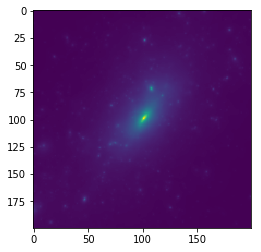

In [12]:
imshow(ktest)

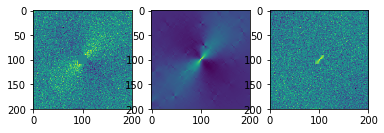

In [13]:
subplot(131);
imshow(g2.real)
subplot(132);
imshow(gtest[1])
subplot(133);
imshow(gtest[1] - g2.real)

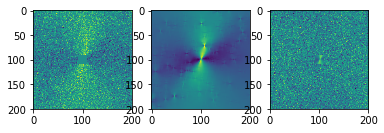

In [14]:
subplot(131);
imshow(g1.real)
subplot(132);
imshow(gtest[0])
subplot(133);
imshow(gtest[0] - g1.real)

In [15]:
tot = gamma_to_kappa(g1,g2)

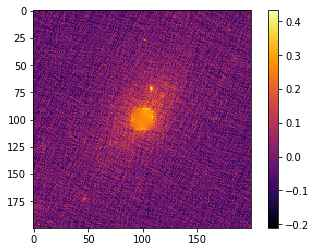

In [18]:
imshow(tot.real,cmap='inferno'); colorbar()

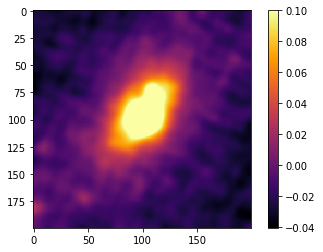

In [23]:
imshow(gaussian_filter(tot.real, sigma=4.),cmap='inferno', vmax = 0.1); colorbar()

In [24]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [25]:
mu = tf.Variable(initial_value=np.zeros(npix*npix), dtype=tf.float32)
sigma = tf.Variable(initial_value=0.01*np.ones(npix*npix), dtype=tf.float32)

# Create the approximate posterior
sigma_mat = tf.nn.softplus(sigma)
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma_mat)
latent_prior = tfd.Laplace(loc=tf.zeros([npix*npix]), scale=0.1*tf.ones([npix*npix]))

In [26]:
in_gamma = tf.placeholder(tf.float32, shape=(2,1,200,200))

# Sample from the posteriors
approx_posterior_sample = approx_posterior.sample(64)

r1,r2 = kappa_to_gamma(tf.reshape(approx_posterior_sample,(-1, 200, 200)))

rate = (approx_posterior.log_prob(approx_posterior_sample) - tf.reduce_sum(latent_prior.log_prob(approx_posterior_sample),axis=1))
distortion = tf.reduce_sum(( tf.real(tf.stack([r1,r2],axis=0)) - in_gamma)**2/(nsig**2), axis=[0,2,3])

elbo_local = -(rate + distortion)
elbo = tf.reduce_mean(elbo_local)
loss = -elbo

In [27]:
# Now, let's optimize :-)
lr = tf.placeholder(tf.float32)
optimizer_code = tf.train.AdamOptimizer(learning_rate=lr)
opt_op_code = optimizer_code.minimize(loss)

In [28]:
sess.run(tf.global_variables_initializer())

In [32]:
losses = []

In [50]:
nepochs = 2000
for ep in range(nepochs):
    _, l = sess.run([opt_op_code, loss], feed_dict={in_gamma: gtest.reshape((2,1, 200,200)), lr:0.001})     
    losses.append(l)
    if ep %10 == 0:
        print(l)

6542339.5
6472738.5
6383800.0
6292511.0
6198305.0
6117728.0
6036028.0


KeyboardInterrupt: 

In [51]:
a1,a2, m, sig = sess.run([r1, r2, mu, sigma_mat])

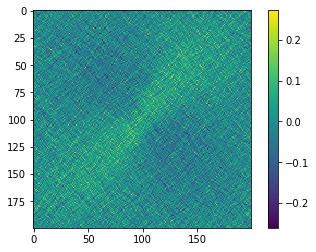

In [52]:
imshow(a2.real.mean(axis=0)); colorbar()

Text(0.5, 1.0, 'Sigma')

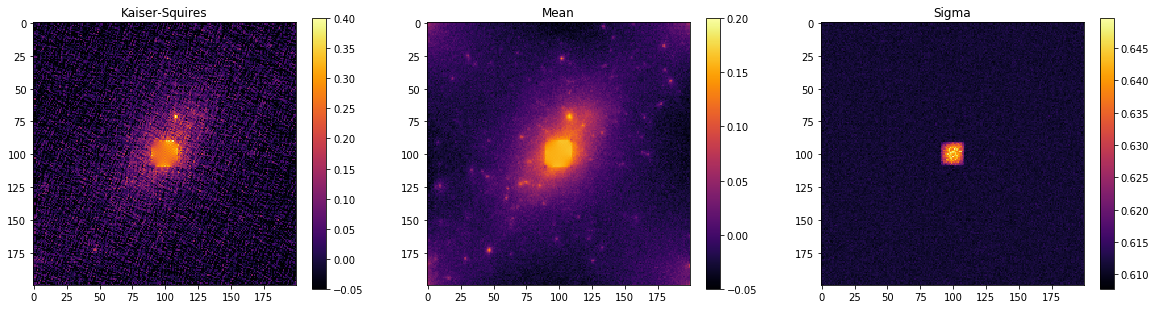

In [53]:
figure(figsize=(20,5))
subplot(131)
imshow(tot.real,vmax=0.4,vmin=-0.05,cmap='inferno'); colorbar()
title('Kaiser-Squires')
subplot(132)
imshow(m.reshape((200,200)),vmax=0.2,vmin=-0.05,cmap='inferno'); colorbar()
title('Mean')
subplot(133)
imshow(sig.reshape((200,200)),cmap='inferno'); colorbar()
title('Sigma')

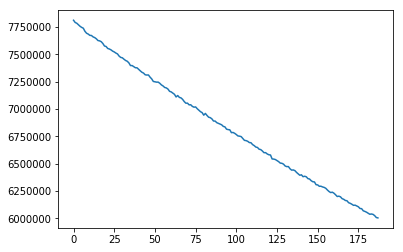

In [54]:
plot(losses)